In [146]:
# Imports using Sklearn make shortcut functions
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Imports
import os
from google.cloud import bigquery

In [147]:
# Environment variables
gcp_project_id = os.environ['GCP_PROJECT']
gcp_service_account_key = os.environ['GCP_SERVICE_ACCOUNT_KEY']
bq_source_dataset = os.environ['BQ_SOURCE_DATASET']
bq_cleaned_dataset = os.environ['BQ_CLEANED_DATASET']

In [148]:
# Import data from BQ and set data to X
# Initialize a BigQuery client using the service account JSON file
bq_client = bigquery.Client(project=gcp_project_id).from_service_account_json(gcp_service_account_key)

# Setting the table we want from the source dataset
select_table = 'cleaned_full_polls_combined_national_results_2004_2019'

# SQL query for querying Big Query and fetching entire table
query = f"""
    SELECT *
    FROM `{gcp_project_id}.{bq_cleaned_dataset}.{select_table}`
"""

In [149]:
# Use BQ client to create DF from the selected table
data = bq_client.query(query).to_dataframe()

/Users/nieksonneveld/.pyenv/versions/3.10.6/envs/election_predictor/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [150]:
# Replace any found NaN values with 0
data.replace(np.nan, 0, inplace=True)

In [151]:
# Add a field 'poll length' that shows number of days the poll was held for
data['poll_length'] = pd.to_datetime(data.enddate) - pd.to_datetime(data.startdate)
data['poll_length'] = data['poll_length'].dt.days

In [153]:
# Divide forecasts by 100 to create values between 0-1
for column in ['BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC', 'UKI_FC']:
    data[column] = data[column] / 100

In [154]:
# Divide actuals by 100 to create values between 0-1
for column in ['BRX_ACT', 'CON_ACT', 'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'NAT_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE']:
    data[column] = data[column] / 100

In [155]:
data.sort_values('enddate', inplace=True)

In [156]:
data.reset_index(inplace=True)

In [157]:
# Drop columns we don't need
data = data.drop(columns=['startdate', 'enddate', 'pollster'])

<Axes: >

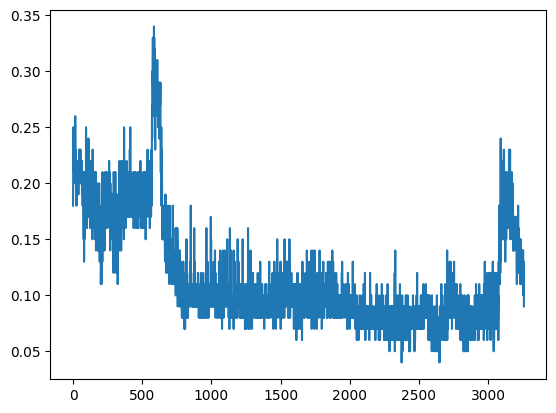

In [158]:
data.LIB_FC.plot()

In [159]:
# Handle numerical transformer
num_columns_selector = ['samplesize', 'days_to_elec', 'poll_length']
num_transformer = MinMaxScaler()

In [160]:
# Handle categorical transformer
cat_columns_selector = ['rating']
cat_transformer = make_pipeline(OrdinalEncoder(categories = [['F','D-','D','D+','C-','B','B+','A-']]),MinMaxScaler())

In [161]:
# Build the preprocessing pipeline
preproc_pipeline = make_column_transformer(
    (num_transformer, num_columns_selector),
    (cat_transformer, cat_columns_selector),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [162]:
from datetime import datetime
# Split data up to 2017 election (TRAIN) and all data related to 2019 election (TEST)
data['next_elec_date'] = data['next_elec_date'].astype("datetime64[ns]")
data_train = data[data['next_elec_date'] < datetime.strptime('2019-12-12', '%Y-%m-%d')]
data_test = data[data['next_elec_date'] == datetime.strptime('2019-12-12', '%Y-%m-%d')]

In [163]:
data_train.columns

Index(['index', 'samplesize', 'rating', 'next_elec_date', 'days_to_elec',
       'BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC',
       'PLC_FC', 'SNP_FC', 'UKI_FC', 'NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE', 'poll_length'],
      dtype='object')

In [164]:
# data.loc[np.where(~data.index.isin(data_train.index))]

,index,samplesize,rating,next_elec_date,days_to_elec,BRX_FC,CON_FC,GRE_FC,LAB_FC,LIB_FC,...,BRX_ACT,CON_ACT,GRE_ACT,LIB_ACT,LAB_ACT,PLC_ACT,SNP_ACT,UKI_ACT,OTH_PERCENTAGE,poll_length
2820,620,1036,A-,2019-12-12,915,0.00,0.39,0.00,0.45,0.07,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,0
2821,621,1005,A-,2019-12-12,908,0.00,0.41,0.01,0.44,0.06,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,0
2822,606,5481,A-,2019-12-12,909,0.00,0.41,0.01,0.46,0.06,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,5
2823,501,2010,A-,2019-12-12,898,0.00,0.39,0.02,0.45,0.05,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,2
2824,622,1016,A-,2019-12-12,897,0.00,0.41,0.02,0.40,0.07,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,561,3005,A-,2019-12-12,2,0.02,0.45,0.02,0.33,0.12,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,1
3256,619,3174,A-,2019-12-12,2,0.04,0.43,0.03,0.34,0.11,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,1
3257,605,2213,A-,2019-12-12,3,0.02,0.44,0.03,0.33,0.12,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,2
3258,361,2815,B+,2019-12-12,3,0.03,0.44,0.03,0.32,0.13,...,0.020127,0.436317,0.02612,0.115477,0.320809,0.004788,0.038812,0.000713,0.036821,2


<Axes: >

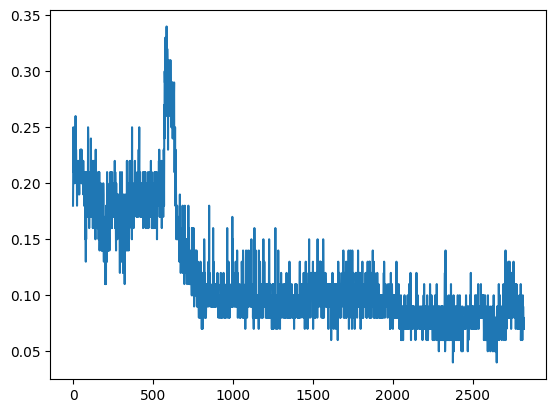

In [165]:
data_train.LIB_FC.plot()
# data.LIB_FC.plot()

In [166]:
# Fit transform preprocessing pipeline to data_train
data_train_processed = preproc_pipeline.fit_transform(data_train)

# Transform preprocessing pipeline to data_test
data_test_processed = preproc_pipeline.transform(data_test)

In [167]:
# Check feature names make sense for data_train
data_train_processed = pd.DataFrame(
    data_train_processed, columns=preproc_pipeline.get_feature_names_out()
)

# Check feature names make sense for data_test
data_test_processed = pd.DataFrame(
    data_test_processed, columns=preproc_pipeline.get_feature_names_out()
)

In [168]:
# Define our X by dropping irrelevant and y columns

X_train = data_train_processed.drop(columns=['next_elec_date','NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE'])

X_test = data_test_processed.drop(columns=['next_elec_date','NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE'])

In [169]:
# Build our target matrix, retaining each party share vote columns only
y_train = data_train_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'NAT_ACT', 'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

# Build our target matrix, retaining each party share vote columns only
y_test = data_test_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'NAT_ACT', 'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

In [170]:
y_train['NAT_ACT'].value_counts()

NAT_ACT
0.000054    1933
0.01901      583
0.000144     254
0.0071        50
Name: count, dtype: int64

In [171]:
# # Handle data splitting
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42
# )

In [172]:
#TODO – refactor the below into a function > model instantiation, fitting, scoring, etc.
# Handle target extraction for test and train sets respectively
#TODO Kwarg > defaults to either cross val or prediction
y_train_LAB = y_train['LAB_ACT']
y_train_CON = y_train['CON_ACT']
y_train_LIB = y_train['LIB_ACT']
y_train_GRE = y_train['GRE_ACT']
y_train_BRX = y_train['BRX_ACT']
y_train_NAT = y_train['NAT_ACT']
y_train_SNP = y_train['SNP_ACT']
y_train_UKI = y_train['UKI_ACT']
y_train_PLC = y_train['PLC_ACT']
y_train_OTH = y_train['OTH_PERCENTAGE']

y_test_LAB = y_test['LAB_ACT']
y_test_CON = y_test['CON_ACT']
y_test_LIB = y_test['LIB_ACT']
y_test_GRE = y_test['GRE_ACT']
y_test_BRX = y_test['BRX_ACT']
y_test_NAT = y_test['NAT_ACT']
y_test_SNP = y_test['SNP_ACT']
y_test_UKI = y_test['UKI_ACT']
y_test_PLC = y_test['PLC_ACT']
y_test_OTH = y_test['OTH_PERCENTAGE']

In [173]:
# Instantiate XGBRegressor Model
xgb_regression_model = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)

In [174]:
# Instantiate the model for each party
model_LAB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_CON = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_LIB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_GRE = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_BRX = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_NAT = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_SNP = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_UKI = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_PLC = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_OTH = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)

In [175]:
# Handle model training
X_train_matrix = np.array(X_train)

model_LAB.fit(X_train_matrix, y_train_LAB)
model_CON.fit(X_train_matrix, y_train_CON)
model_LIB.fit(X_train_matrix, y_train_LIB)
model_GRE.fit(X_train_matrix, y_train_GRE)
model_BRX.fit(X_train_matrix, y_train_BRX)
model_NAT.fit(X_train_matrix, y_train_NAT)
model_SNP.fit(X_train_matrix, y_train_SNP)
model_UKI.fit(X_train_matrix, y_train_UKI)
model_PLC.fit(X_train_matrix, y_train_PLC)
model_OTH.fit(X_train_matrix, y_train_OTH)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [176]:
cv_score_LAB = cross_val_score(model_LAB, X_train_matrix, y_train_LAB).mean()
cv_score_CON = cross_val_score(model_CON, X_train_matrix, y_train_CON).mean()
cv_score_LIB = cross_val_score(model_LIB, X_train_matrix, y_train_LIB).mean()
cv_score_GRE = cross_val_score(model_GRE, X_train_matrix, y_train_GRE).mean()
cv_score_BRX = cross_val_score(model_BRX, X_train_matrix, y_train_BRX).mean()
cv_score_NAT = cross_val_score(model_NAT, X_train_matrix, y_train_NAT).mean()
cv_score_SNP = cross_val_score(model_SNP, X_train_matrix, y_train_SNP).mean()
cv_score_UKI = cross_val_score(model_UKI, X_train_matrix, y_train_UKI).mean()
cv_score_PLC = cross_val_score(model_PLC, X_train_matrix, y_train_PLC).mean()
cv_score_OTH = cross_val_score(model_OTH, X_train_matrix, y_train_OTH).mean()

In [177]:
# Evaluate model performance with cross validation
X_test_matrix = np.array(X_test)

y_pred_LAB = model_LAB.predict(X_test_matrix)
y_pred_CON = model_CON.predict(X_test_matrix)
y_pred_LIB = model_LIB.predict(X_test_matrix)
y_pred_GRE = model_GRE.predict(X_test_matrix)
y_pred_BRX = model_BRX.predict(X_test_matrix)
y_pred_NAT = model_NAT.predict(X_test_matrix)
y_pred_SNP = model_SNP.predict(X_test_matrix)
y_pred_UKI = model_UKI.predict(X_test_matrix)
y_pred_PLC = model_PLC.predict(X_test_matrix)
y_pred_OTH = model_OTH.predict(X_test_matrix)

# Going to try model.evaluate on test data instead of cross_val
score_LAB = cross_val_score(model_LAB, X_test_matrix, y_test_LAB).mean()
score_CON = cross_val_score(model_CON, X_test_matrix, y_test_CON).mean()
score_LIB = cross_val_score(model_LIB, X_test_matrix, y_test_LIB).mean()
score_GRE = cross_val_score(model_GRE, X_test_matrix, y_test_GRE).mean()
score_BRX = cross_val_score(model_BRX, X_test_matrix, y_test_BRX).mean()
score_NAT = cross_val_score(model_NAT, X_test_matrix, y_test_NAT).mean()
score_SNP = cross_val_score(model_SNP, X_test_matrix, y_test_SNP).mean()
score_UKI = cross_val_score(model_UKI, X_test_matrix, y_test_UKI).mean()
score_PLC = cross_val_score(model_PLC, X_test_matrix, y_test_PLC).mean()
score_OTH = cross_val_score(model_OTH, X_test_matrix, y_test_OTH).mean()

In [178]:
print(f"2019 prediction for LAB: {y_pred_LAB.mean()}")
print(f"2019 prediction for CON: {y_pred_CON.mean()}")
print(f"2019 prediction for LIB: {y_pred_LIB.mean()}")
print(f"2019 prediction for GRE: {y_pred_GRE.mean()}")
print(f"2019 prediction for BRX: {y_pred_BRX.mean()}")
print(f"2019 prediction for NAT: {y_pred_NAT.mean()}")
print(f"2019 prediction for SNP: {y_pred_SNP.mean()}")
print(f"2019 prediction for UKI: {y_pred_UKI.mean()}")
print(f"2019 prediction for PLC: {y_pred_PLC.mean()}")
print(f"2019 prediction for OTH: {y_pred_OTH.mean()}")

2019 prediction for LAB: 0.39958274364471436
2019 prediction for CON: 0.42314398288726807
2019 prediction for LIB: 0.13362880051136017
2019 prediction for GRE: 0.01439526118338108
2019 prediction for BRX: 0.0
2019 prediction for NAT: 0.0073031410574913025
2019 prediction for SNP: 0.027578406035900116
2019 prediction for UKI: 0.01866842992603779
2019 prediction for PLC: 0.005164195317775011
2019 prediction for OTH: 0.03511128947138786


In [184]:
print(f"2019 prediction for LAB: {y_pred_LAB[-25:-1].mean()}")
print(f"2019 prediction for CON: {y_pred_CON[-25:-1].mean()}")
print(f"2019 prediction for LIB: {y_pred_LIB[-25:-1].mean()}")
print(f"2019 prediction for GRE: {y_pred_GRE[-25:-1].mean()}")
print(f"2019 prediction for BRX: {y_pred_BRX[-25:-1].mean()}")
print(f"2019 prediction for NAT: {y_pred_NAT[-25:-1].mean()}")
print(f"2019 prediction for SNP: {y_pred_SNP[-25:-1].mean()}")
print(f"2019 prediction for UKI: {y_pred_UKI[-25:-1].mean()}")
print(f"2019 prediction for PLC: {y_pred_PLC[-25:-1].mean()}")
print(f"2019 prediction for OTH: {y_pred_OTH[-25:-1].mean()}")

2019 prediction for LAB: 0.398836225271225
2019 prediction for CON: 0.4230569899082184
2019 prediction for LIB: 0.22799384593963623
2019 prediction for GRE: 0.012784012593328953
2019 prediction for BRX: 0.0
2019 prediction for NAT: 0.01876816526055336
2019 prediction for SNP: 0.02330639958381653
2019 prediction for UKI: 0.01961888186633587
2019 prediction for PLC: 0.005164195317775011
2019 prediction for OTH: 0.038207393139600754


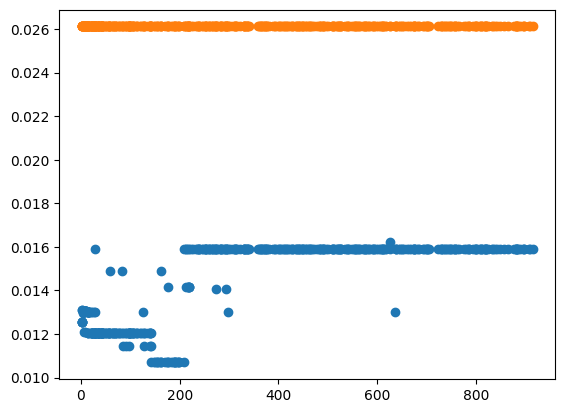

In [200]:
plt.scatter(y=y_pred_GRE,x=data_test['days_to_elec'])
plt.scatter(y=y_test_GRE,x=data_test['days_to_elec'])

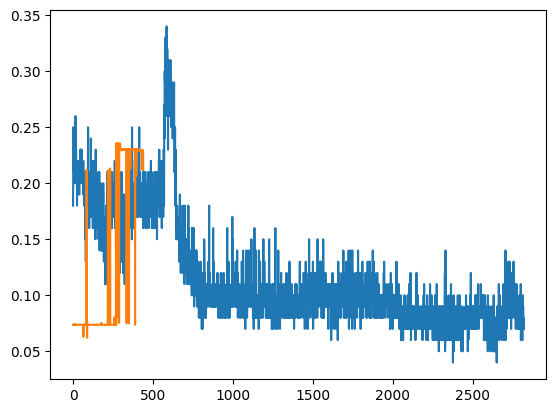

In [181]:
plt.plot(data_train['LIB_FC'])
plt.plot(y_pred_LIB)
# plt.plot(data_test_processed['rating'])
plt.show;

In [182]:
# Manually calculating MSE for each prediction
mse_pred_LAB = mean_squared_error(y_pred_LAB,y_test_LAB)
r2_LAB = r2_score(y_pred_LAB,y_test_LAB)

In [183]:
print(f"R^2 score for LAB: {score_LAB}")
print(f"R^2 score for CON: {score_CON}")
print(f"R^2 score for LIB: {score_LIB}")
print(f"R^2 score for GRE: {score_GRE}")
print(f"R^2 score for BRX: {score_BRX}")
print(f"R^2 score for NAT: {score_NAT}")
print(f"R^2 score for SNP: {score_SNP}")
print(f"R^2 score for UKI: {score_UKI}")
print(f"R^2 score for PLC: {score_PLC}")
print(f"R^2 score for OTH: {score_OTH}")

R^2 score for LAB: 1.0
R^2 score for CON: 1.0
R^2 score for LIB: 1.0
R^2 score for GRE: 1.0
R^2 score for BRX: 1.0
R^2 score for NAT: 1.0
R^2 score for SNP: 1.0
R^2 score for UKI: 1.0
R^2 score for PLC: 1.0
R^2 score for OTH: 1.0
